In [35]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import *
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import Input
from keras import initializers
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from scipy import signal
from skimage.restoration import denoise_tv_chambolle
from skimage.filters import gaussian
from keras.utils.np_utils import to_categorical
import json
import pandas as pd
import random
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
K.set_image_dim_ordering('tf')

data = pd.read_json('train.json')

data = data.drop('id', 1)
data = data.drop('inc_angle', 1)



In [36]:
Y = data['is_iceberg']

data = data.drop('is_iceberg', 1)


In [37]:
X1 = data['band_1']
X2 = data['band_2']
X1 = np.array(X1)
X2 = np.array(X2)

In [38]:
X_R1 = np.array([denoise_tv_chambolle(np.array(i), weight=0.05).reshape(75, 75, 1) for i in X1])
X_R2 = np.array([denoise_tv_chambolle(np.array(i), weight=0.05).reshape(75, 75, 1) for i in X2])
X_R1.shape

(1604, 75, 75, 1)

In [39]:
Y = to_categorical(Y)

Y.shape

(1604, 2)

In [40]:
image_height = 75
image_width = 75

train_samples = 1300
validation_samples = 304

epochs = 40
batch_size = 32
number_of_classes = 2

X_train_1 = X_R1[:train_samples, :, : ,:]
X_train_1 = abs(X_train_1/(np.max(X_train_1) - np.min(X_train_1)))
X_train_2 = X_R2[:train_samples, :, : ,:]
X_train_2 = abs(X_train_2/(np.max(X_train_2) - np.min(X_train_2)))
X_test_1 = X_R1[train_samples:, :, :, :]
X_test_1 = abs(X_test_1/(np.max(X_test_1) - np.min(X_test_1)))
X_test_2 = X_R2[train_samples:, :, :, :]
X_test_2 = abs(X_test_2/(np.max(X_test_2) - np.min(X_test_2)))

Y_train = Y[:train_samples, :]
Y_test = Y[train_samples:, :]

print(X_R1.shape)
print(X_train_1.shape)
print(X_test_1.shape)
print(Y_train.shape)
print(Y_test.shape)

(1604, 75, 75, 1)
(1300, 75, 75, 1)
(304, 75, 75, 1)
(1300, 2)
(304, 2)


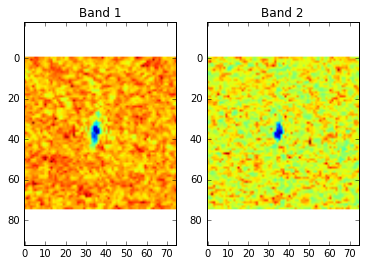

In [41]:
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

sample_image = (X_train_1[0])
sample_image = np.reshape(sample_image, (75,75))
ax1.imshow(sample_image)
ax1.set_title("Band 1")
sample_image = (X_train_2[0])
sample_image = np.reshape(sample_image, (75,75))
ax2.imshow(sample_image)
ax2.set_title("Band 2")

In [44]:
# Alternative go at multiple inputs

band_input_B1 = Input(shape=(image_width, image_height, 1))
band_input_B2 = Input(shape=(image_width, image_height, 1))

# Band 1 architecture
# CNN1
CNN_L1_B1 = Conv2D(32, (3, 3))(band_input_B1)
CNN_L1_B1 = LeakyReLU(alpha=.01)(CNN_L1_B1)
CNN_L1_B1 = MaxPooling2D(pool_size=(2, 2))(CNN_L1_B1)

# CNN2
CNN_L2_B1 = BatchNormalization()(CNN_L1_B1)
CNN_L2_B1 = Conv2D(64, (3, 3))(CNN_L2_B1)
CNN_L2_B1 = LeakyReLU(alpha=.01)(CNN_L2_B1)
CNN_L2_B1 = MaxPooling2D(pool_size=(2, 2))(CNN_L2_B1)

# CNN3
CNN_L3_B1 = BatchNormalization()(CNN_L2_B1)
CNN_L3_B1 = Conv2D(128, (3, 3))(CNN_L3_B1)
CNN_L3_B1 = LeakyReLU(alpha=.01)(CNN_L3_B1)
CNN_L3_B1 = MaxPooling2D(pool_size=(2, 2))(CNN_L3_B1)

# CNN4
CNN_L4_B1 = BatchNormalization()(CNN_L3_B1)
CNN_L4_B1 = Conv2D(256, (3, 3))(CNN_L4_B1)
CNN_L4_B1 = LeakyReLU(alpha=.01)(CNN_L4_B1)
CNN_L4_B1 = MaxPooling2D(pool_size=(2, 2))(CNN_L4_B1)

# CNN output
CNN_OUT_B1 = Flatten()(CNN_L4_B1)
CNN_OUT_B1 = BatchNormalization()(CNN_OUT_B1)

# Band 2 architecture
# CNN1
CNN_L1_B2 = Conv2D(32, (3, 3))(band_input_B2)
CNN_L1_B2 = LeakyReLU(alpha=.01)(CNN_L1_B2)
CNN_L1_B2 = MaxPooling2D(pool_size=(2, 2))(CNN_L1_B2)

# CNN2
CNN_L2_B2 = BatchNormalization()(CNN_L1_B2)
CNN_L2_B2 = Conv2D(64, (3, 3))(CNN_L2_B2)
CNN_L2_B2 = LeakyReLU(alpha=.01)(CNN_L2_B2)
CNN_L2_B2 = MaxPooling2D(pool_size=(2, 2))(CNN_L2_B2)

# CNN3
CNN_L3_B2 = BatchNormalization()(CNN_L2_B2)
CNN_L3_B2 = Conv2D(128, (3, 3))(CNN_L3_B2)
CNN_L3_B2 = LeakyReLU(alpha=.01)(CNN_L3_B2)
CNN_L3_B2 = MaxPooling2D(pool_size=(2, 2))(CNN_L3_B2)

# CNN4
CNN_L4_B2 = BatchNormalization()(CNN_L3_B2)
CNN_L4_B2 = Conv2D(256, (3, 3))(CNN_L4_B2)
CNN_L4_B2 = LeakyReLU(alpha=.01)(CNN_L4_B2)
CNN_L4_B2 = MaxPooling2D(pool_size=(2, 2))(CNN_L4_B2)

# CNN output
CNN_OUT_B2 = Flatten()(CNN_L4_B2)
CNN_OUT_B2 = BatchNormalization()(CNN_OUT_B2)

# Concat bands
MERGE_LAYER = concatenate([CNN_OUT_B1, CNN_OUT_B2])

# Deep layers processing
# L1
DL_L1 = BatchNormalization()(MERGE_LAYER)
DL_L1 = Dense(512, use_bias=True, bias_initializer='zeros')(DL_L1)
DL_L1 = LeakyReLU(alpha=.01)(DL_L1)
DL_L1 = Dropout(0.15)(DL_L1)

# L2
DL_L2 = BatchNormalization()(DL_L1)
DL_L2 = Dense(256, use_bias=True, bias_initializer='zeros')(DL_L2)
DL_L2 = LeakyReLU(alpha=.01)(DL_L2)
DL_L2 = Dropout(0.15)(DL_L2)

# L3
DL_L3 = BatchNormalization()(DL_L2)
DL_L3 = Dense(128, use_bias=True, bias_initializer='zeros')(DL_L3)
DL_L3 = LeakyReLU(alpha=.01)(DL_L3)
DL_L3 = Dropout(0.15)(DL_L3)

# L4
DL_L4 = BatchNormalization()(DL_L3)
DL_L4 = Dense(64, use_bias=True, bias_initializer='zeros')(DL_L4)
DL_L4 = LeakyReLU(alpha=.01)(DL_L4)
DL_L4 = Dropout(0.15)(DL_L4)

OUTPUT = Dense(number_of_classes, activation='softmax')(DL_L4)

model = Model(inputs = [band_input_B1, band_input_B2], outputs=OUTPUT)

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
# model.summary()

In [45]:
model.fit([X_train_1, X_train_2], Y_train,
              batch_size=batch_size, validation_data=([X_test_1, X_test_2], Y_test),
              epochs=epochs,
                shuffle=True)

Train on 1300 samples, validate on 304 samples
Epoch 1/40
1300/1300 [==============================] - 19s - loss: 0.6026 - acc: 0.7100 - val_loss: 0.7407 - val_acc: 0.3355
Epoch 2/40
1300/1300 [==============================] - 14s - loss: 0.4211 - acc: 0.7985 - val_loss: 0.8985 - val_acc: 0.3355
Epoch 3/40
1300/1300 [==============================] - 14s - loss: 0.3436 - acc: 0.8523 - val_loss: 0.9757 - val_acc: 0.3355
Epoch 4/40
1300/1300 [==============================] - 14s - loss: 0.2862 - acc: 0.8638 - val_loss: 0.6430 - val_acc: 0.6612
Epoch 5/40
1300/1300 [==============================] - 14s - loss: 0.2475 - acc: 0.8908 - val_loss: 1.1335 - val_acc: 0.3355
Epoch 6/40
1300/1300 [==============================] - 14s - loss: 0.2183 - acc: 0.9069 - val_loss: 0.6285 - val_acc: 0.6382
Epoch 7/40
1300/1300 [==============================] - 14s - loss: 0.1530 - acc: 0.9369 - val_loss: 1.7885 - val_acc: 0.3355
Epoch 8/40
1300/1300 [==============================] - 14s - loss: 0.1

In [35]:
Y_pred = model1.predict(X_test)

In [36]:
for i in range(len(Y_pred)):
    Y_pred[i, :] = np.round(Y_pred[i, :])

In [37]:
#Precision: how many 1 are true 1?
#Recall: how many 0 are true 0? 
#F1Score: balance between those two

y_comp = confusion_matrix(Y_test[:, 1], Y_pred[:, 1])
precision = y_comp[1, 1] / (y_comp[0, 1] + y_comp[1, 1])
recall = y_comp[1, 1] / (y_comp[1, 0] + y_comp[1, 1])
accuracy = accuracy_score(Y_test[:, 1], Y_pred[:, 1])
f1score = 2 * precision * recall / (precision + recall)
print("AC:%.2f PR:%.2f RE:%.2f F1:%.2f" % (accuracy, precision, recall, f1score))

AC:0.79 PR:0.64 RE:0.86 F1:0.73


In [38]:
filename = ("model_%i_%i_%i_%i.h5" % (accuracy*100, precision*100, recall*100, f1score*100))
model1.save(filename)

In [ ]:
test = pd.read_json('test.json')

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)